## UNIVERSIDAD DE BUENOS AIRES - FACULTAD DE INGENIERÍA

**75.06/95.58 Organización de Datos
Segundo Cuatrimestre de 2018
Trabajo Práctico 1: Web analytics de www.trocafone.com**

Grupo 42:
Miranda, Pablo
Marinier, Sebastián
Farfán, Verónica
Basconcelo, Eliana

### *Carga de Librerias, set de datos y establecimiento de gráficos*

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

In [2]:
# Change working directory
os.chdir('C:/Users/vfarfan/OD')
# Load the data
#df = pd.read_csv("C:/Users/eliana.basconcelo/Desktop/events.csv", dtype={'sku' : 'object'}) # sku como object para poder eliminar el .0 en los str
df = pd.read_csv("data/events.csv", dtype={'sku' : 'object'}) # sku como object para poder eliminar el .0 en los str
#df = pd.read_csv(r"C:\Users\matias\Desktop\Organizacion de Datos\CSVs\events.csv", dtype={'sku' : 'object'}) # sku como object para poder eliminar el .0 en los str

## 1.Introducción

El objetivo del siguiente informe es analizar los datos de un conjunto de eventos web de usuarios que visitaron el sitio web www.trocafone.com. El análisis a realizar se va a centrar en explorar y extraer información pertinente para la empresa en forma de insights que puedan aportar conocimiento de los usuarios y del comportamiento de los mismos cuando interactúan con el sitio web.

### Información contenida en el archivo (columnas)

In [3]:
print(df.columns.values)

['timestamp' 'event' 'person' 'url' 'sku' 'model' 'condition' 'storage'
 'color' 'skus' 'search_term' 'staticpage' 'campaign_source'
 'search_engine' 'channel' 'new_vs_returning' 'city' 'region' 'country'
 'device_type' 'screen_resolution' 'operating_system_version'
 'browser_version']


### Eventos posibles para los usuarios

In [4]:
print(df['event'].unique())

['ad campaign hit' 'visited site' 'viewed product' 'checkout'
 'generic listing' 'search engine hit' 'brand listing' 'searched products'
 'conversion' 'staticpage' 'lead']


## 2. Preprocesamiento y descripción de Datos

### Preprocesamiento de Datos

#### Procesar el campo SKU para eliminar el .0
Algunos SKUs están cargados con un .0 como si fueran decimales.  Los levantamos como string y eliminamos el .0 para normalizar el dato.

In [5]:
print(df.loc[df['sku'].isnull(),'event'].unique())
print(df.loc[df['sku'].notnull(),'event'].unique())

['ad campaign hit' 'visited site' 'generic listing' 'search engine hit'
 'brand listing' 'searched products' 'staticpage' 'lead']
['viewed product' 'checkout' 'conversion']


In [6]:
df.loc[df['sku'].apply(type) == str,'sku'] = df.loc[df['sku'].apply(type) == str,'sku'].str.replace('\.0', '')

#### Procesar el campo SKU para eliminar valores undefined

In [7]:
print(df.loc[df['sku'] == 'undefined',:]['person'])
df.loc[df['person'] == '602b3649','sku'].apply(type)
df.loc[df['person'] == '655402b0',:]

368097    602b3649
387149    655402b0
Name: person, dtype: object


,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
387149,2018-05-22 13:44:53,checkout,655402b0,NaN,undefined,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387150,2018-05-22 13:44:53,visited site,655402b0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Direct,New,Unknown,Unknown,Brazil,Computer,1366x768,Windows 7,Chrome 66.0


Existen dos eventos checkout con sku="undefined". Son nuevos usuarios, visitaron el sitio e hicieron checkout sin elegir producto. Elegimos eliminar la sesión del usuario que contenga estos registros 'undefined'.

In [8]:
# Elimino SKUs "undefined"
df = df.loc[df['sku'] != 'undefined',:]

#### Convertir datos categóricos

In [9]:
# Convert data types
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['event'] = pd.Categorical(df['event'])
#df['person']
df['url'] = pd.Categorical(df['url'])
df['sku'] = pd.Categorical(df['sku'])
df['model'] = pd.Categorical(df['model'])
df['condition'] = pd.Categorical(df['condition'])
df['storage'] = pd.Categorical(df['storage'])
df['color'] = pd.Categorical(df['color'])
#df['skus'] = pd.Categorical(df['skus'])
#df['search_term']
df['staticpage'] = pd.Categorical(df['staticpage'])
df['campaign_source'] = pd.Categorical(df['campaign_source'])
df['search_engine'] = pd.Categorical(df['search_engine'])
df['channel'] = pd.Categorical(df['channel'])
df['new_vs_returning'] = pd.Categorical(df['new_vs_returning'])
df['city'] = pd.Categorical(df['city'])
df['region'] = pd.Categorical(df['region'])
df['country'] = pd.Categorical(df['country'])
df['device_type'] = pd.Categorical(df['device_type'])
df['screen_resolution'] = pd.Categorical(df['screen_resolution'])
df['operating_system_version'] = pd.Categorical(df['operating_system_version'])
df['browser_version'] = pd.Categorical(df['browser_version'])


#### Agregar columnas para día y mes

In [10]:
df['day'] = df['timestamp'].dt.to_period('D').dt.to_timestamp()
df['month'] = df['timestamp'].dt.to_period('M').dt.to_timestamp()

#### Agregar columna con la Marca extraída del campo model
La primer palabra en este campo corresponde a la marca del producto.

In [11]:
df['brand'] = pd.Categorical(df['model'].str.split(' ').str.get(0))

#### Eliminar registros que no correspondan a Brasil
Si analizamos la totalidad de registros. Nos encontramos con que hay un número de personas que solo tienen el evento checkout. No es coherente con nuestra progresión de compra y también sabemos que no pertenecen a Brasil. Por lo tanto, hemos decidido excluirlos.

Usuarios que sólo tienen eventos checkout: 471


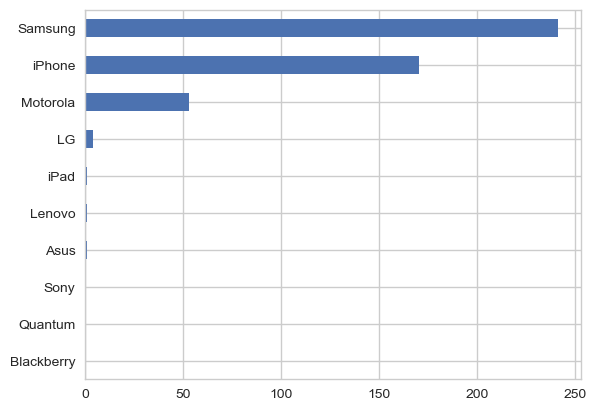

In [12]:
# Vemos que 471 personas no tienen otro evento además de checkout.

# Podemos analizar para éstos qué productos eligen.  ¿Qué puede aportar esto?

# Obtener personas que sólo tienen eventos checkout
data = pd.DataFrame({'person':df.loc[df['event'] == 'checkout','person'].unique()
             }).merge(df.loc[df['event'] != 'checkout',('person','timestamp')], how='left')
# Buscar datos de personas que sólo tienen eventos checkout
data = pd.DataFrame({'person':data.loc[data['timestamp'].isnull(),'person'].unique()}).merge(df)
print('Usuarios que sólo tienen eventos checkout:', data['person'].nunique())
data['brand'].value_counts(ascending=True).plot.barh()
plt.show()

#### Eliminar registros que no correspondan a Brasil
Nos quedamos sólo con datos de Brasil únicamente por ser representativos del total de datos.  De esta forma, todos los usuarios que analizamos tendrán un visited site y además excluimos los usuarios que sólo tienen un evento checkout.

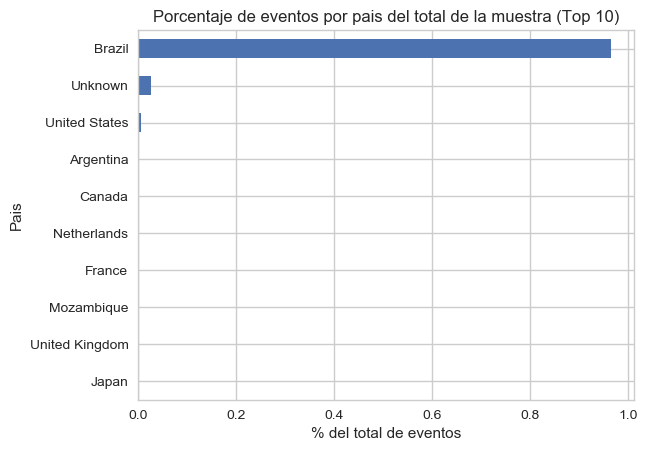

In [13]:
df['country'].value_counts(normalize=True, ascending=True)[-10:].plot.barh()
plt.ylabel('Pais')
plt.xlabel('% del total de eventos')
plt.title('Porcentaje de eventos por pais del total de la muestra (Top 10)')
plt.show()



In [14]:
# Filtramos para quedarnos sólo con los usuarios de Brasil
df = pd.DataFrame({'person':df.loc[df['country']=='Brazil',('person')].unique()}).merge(df, how='inner')

#### Descripción del nuevo dataset

In [15]:
df.describe()

,person,timestamp,event,url,sku,model,condition,storage,color,skus,...,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,day,month,brand
count,987602,987602,987602,80797,550514,550953,550514,550514,550514,216798,...,85398,85398,85398,85398,85398,85398,85398,987602,987602,550953
unique,25872,777135,11,226,2204,202,5,8,63,34938,...,1874,53,17,4,272,120,334,166,6,10
top,71492f2b,2018-05-15 15:56:06,viewed product,/,2830,iPhone 6,Bom,16GB,Preto,"2820,6706,6720,2750,6649,7251,6663,12604,7224,...",...,Unknown,Sao Paulo,Brazil,Smartphone,360x640,Windows 7,Chrome 66.0,2018-05-15 00:00:00,2018-05-01 00:00:00,iPhone
freq,2771,11,517566,27745,4343,49774,237346,186205,129430,579,...,14322,24996,84308,43481,29492,19097,22002,25002,463206,251484
first,NaN,2018-01-01 07:32:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,2018-01-01 00:00:00,NaN
last,NaN,2018-06-15 23:59:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-06-15 00:00:00,2018-06-01 00:00:00,NaN


#### Período de tiempo en el cual se realiza el análisis

In [16]:
print(min(df['timestamp']))
print(max(df['timestamp']))

2018-01-01 07:32:26
2018-06-15 23:59:31


## 3. Análisis de Datos

### 3.1 Clientes

##### 3.1.1 Total de Usuarios

In [17]:
print("Clientes")
print(df['person'].nunique())

Clientes
25872


#### Ingreso de clientes al sitio: new y returning

Considerando todos los eventos "visited site", que es cuando el sitio registra un usuario, podemos saber desde donde ingresan (sin discriminar entre usuarios nuevos y que retornan) 

Dispositivos desde el cual acceden los Clientes:
Smartphone    43481
Computer      40616
Tablet         1187
Unknown         114
Name: device_type, dtype: int64


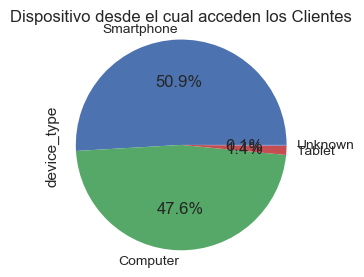

In [18]:
print('Dispositivos desde el cual acceden los Clientes:')
print(df['device_type'].value_counts(ascending=False))
df['device_type'].value_counts().plot.pie(figsize = (3,3),autopct='%1.1f%%')
plt.title('Dispositivo desde el cual acceden los Clientes')
plt.axis('equal')
plt.show()

Top 10 de browser utilizado cuando ingresan por Smartphone:
Chrome Mobile 66.0      17139
Chrome Mobile 65.0       5620
Chrome Mobile 64.0       3061
Chrome Mobile 67.0       2607
Mobile Safari 11         1986
Chrome Mobile 39         1612
Chrome Mobile 63.0       1398
Samsung Internet 6.4     1035
Mobile Safari 10          600
Chrome Mobile 62.0        562
Name: browser_version, dtype: int64


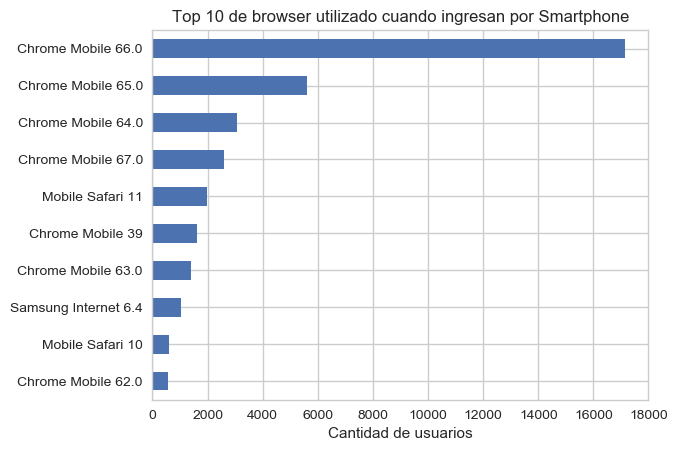

In [19]:
print('Top 10 de browser utilizado cuando ingresan por Smartphone:')
print(df.loc[df['device_type']== 'Smartphone','browser_version'].value_counts().head(10))
df.loc[df['device_type']== 'Smartphone','browser_version'].value_counts(ascending=True).tail(10).plot.barh()
plt.xlabel('Cantidad de usuarios')
plt.title('Top 10 de browser utilizado cuando ingresan por Smartphone')
plt.show()

Top 10 de browser utilizado cuando ingresan por la Computadora
Chrome 66.0      21481
Chrome 65.0       6247
Chrome 67.0       2884
Chrome 64.0       2380
Chrome 63.0       1428
Firefox 60        1029
Firefox 59         913
Edge 16.16299      593
Chrome 49.0        574
IE 11              370
Name: browser_version, dtype: int64


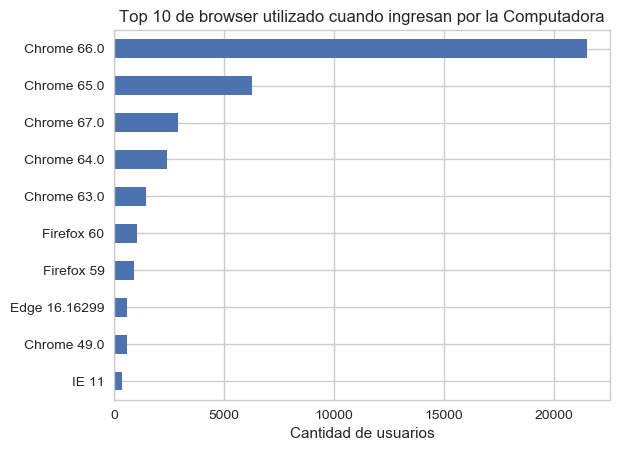

In [20]:
print('Top 10 de browser utilizado cuando ingresan por la Computadora')
print(df.loc[df['device_type']== 'Computer','browser_version'].value_counts().head(10))
df.loc[df['device_type']== 'Computer','browser_version'].value_counts(ascending=True).tail(10).plot.barh()
plt.xlabel('Cantidad de usuarios')
plt.title('Top 10 de browser utilizado cuando ingresan por la Computadora')
plt.show()

##### 3.1.2 Nuevos clientes
Los nuevos clientes son registrados cuando ocurre el evento visited site. Usan en línea con la totalidad de usuarios Smartphones y Computadoras para ingresar, con Chrome (ya sea versión desktop o mobile), y llegan por el canal Paid.

In [21]:
df['new_vs_returning'].unique()
dfnew = df.loc[df['new_vs_returning'] == 'New',] # 26898
print("\nEvento por el cual llegan nuevos clientes")
print(dfnew['event'].value_counts().head(2))
print("\nDispositivo más usado por nuevos clientes")
print(dfnew['device_type'].value_counts())
#dfnew['operating_system'].value_counts()
print('\nBrowser más usados por nuevos clientes')
print(dfnew['browser_version'].value_counts().head(10))


Evento por el cual llegan nuevos clientes
visited site      25871
viewed product        0
Name: event, dtype: int64

Dispositivo más usado por nuevos clientes
Smartphone    13850
Computer      11528
Tablet          452
Unknown          41
Name: device_type, dtype: int64

Browser más usados por nuevos clientes
Chrome 66.0           6973
Chrome Mobile 66.0    5093
Chrome Mobile 39      1590
Chrome 67.0           1320
Chrome Mobile 67.0    1124
Chrome Mobile 65.0    1041
Chrome 65.0            856
Mobile Safari 11       707
Chrome Mobile 64.0     573
Chrome 64.0            421
Name: browser_version, dtype: int64



Nuevos clientes llegan principalmente por el canal Paid
Paid        17283
Organic      5331
Direct       2136
Referral      659
Social        451
Email          10
Unknown         1
Name: channel, dtype: int64


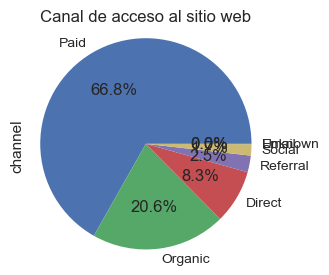

In [22]:
print("\nNuevos clientes llegan principalmente por el canal Paid")
print(dfnew['channel'].value_counts())
dfnew['channel'].value_counts().plot.pie(figsize = (3,3),autopct='%1.1f%%')
plt.title('Canal de acceso al sitio web')
plt.axis('equal')
plt.show()

#### Clientes nuevos a través del tiempo
Hay un pico de nuevos clientes a mediados de mayo.  A qué se debe?

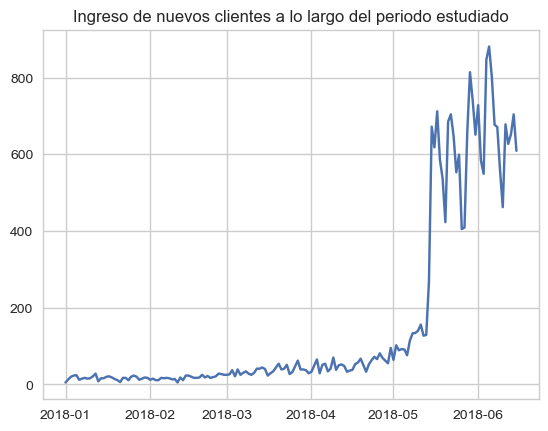

In [23]:
dfnew = df.loc[df['new_vs_returning'] == 'New',('day', 'new_vs_returning')].groupby('day').count()
dfnew
plt.plot(dfnew)
plt.title('Ingreso de nuevos clientes a lo largo del periodo estudiado')
plt.show()

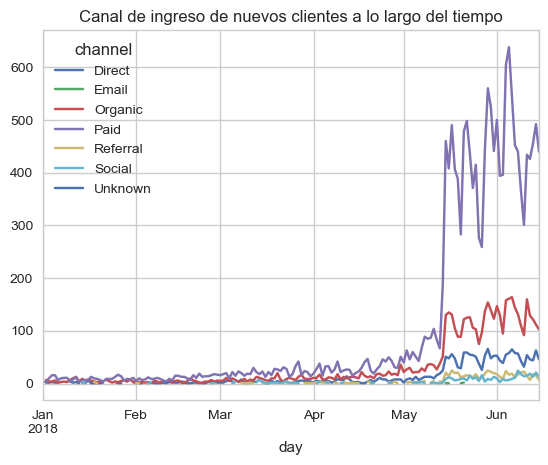

In [24]:
dfnew = df.loc[df['new_vs_returning'] == 'New',('day', 'channel')].groupby(['day','channel'])['channel'].count().to_frame().unstack()\
            .plot(y='channel', title='Canal de ingreso de nuevos clientes a lo largo del tiempo')

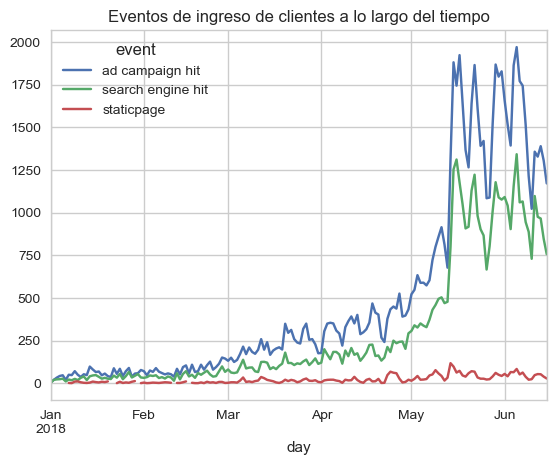

In [25]:
df_overtime = df.groupby(['day','event'])['event'].count().unstack()
df_overtime = df_overtime[['ad campaign hit','search engine hit','staticpage']]
df_overtime.plot(title='Eventos de ingreso de clientes a lo largo del tiempo')

Si el pico de ingresos al sitio entre mayo y junio fue mediante el canal Paid y estudiando la evolución de los 3 eventos de ingreso según nuestra progresión: ad campaign hit, search engine hit, static page, podemos decir que el evento ad campaign hit provocó este pico. ¿Qué clase de campaña se llevó a cabo? El resultado indica que el pico de ingresos a mediados de mayo por canal paid resultado del evento ad campaign hit, se debió a campañas hechas en Google.

Total de campañas llevadas a cabo:
google              56747
criteo               9480
rtbhouse             8354
zanox                1606
emblue               1341
FacebookAds           732
afilio                684
bing                  474
voxus                 427
rakuten               308
indexa                154
buscape               140
manifest              126
Facebook               73
datacrush              59
blog                   37
afiliado               34
yotpo                  24
mercadopago            15
FacebookSocial          8
MARKETING SOCIAL        7
onsite                  3
Google Social           1
socialmedia             1
Name: campaign_source, dtype: int64


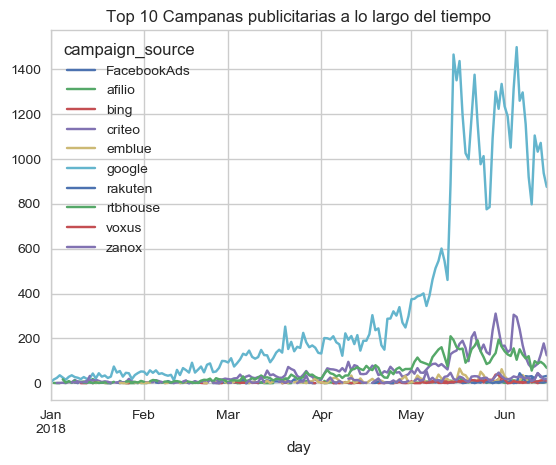

In [26]:
print('Total de campañas llevadas a cabo:')
print(df['campaign_source'].value_counts())

list_source = df['campaign_source'].value_counts().head(10)
list_source = list(list_source.index.values)
df_campaign = df.loc[df['event'] == 'ad campaign hit',['day','campaign_source']]
df_campaign = df_campaign[df_campaign['campaign_source'].isin(list_source)].groupby(['day','campaign_source'])['campaign_source'].count().unstack().plot(title='Top 10 Campanas publicitarias a lo largo del tiempo')


Las campañas de Google, también explican en gran medida, el ingresos de nuevos clientes a lo largo de todo el período estudiado pero en mayor medida desde mayo en adelante. 

Por supuesto, que una vez que un usuario ingresa al sitio, realiza el evento de mirar productos y este ha aumentado con el mismo comportamiento a medidados de mayo. Y crece y decrece acompañado de la efectividad del anuncio de Google. 

Nuestra recomendación es realizar Ads a través de los 3 primeros mecanismos con mayores hits. Por otro lado, si desea hacer Ads mediante las 10 primeras vías de hits, recomendamos incrementar el targeting centrado en las marcas buscadas por ej.

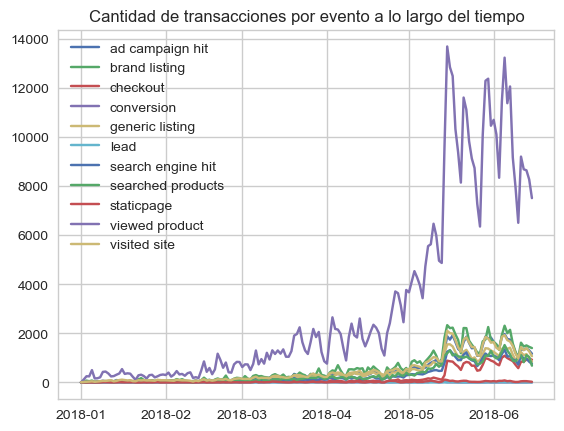

In [27]:
df2 = df.loc[:,('day', 'event', 'timestamp')].groupby(['day', 'event']).count().fillna(0)
df2 = df2.unstack()
# elimino el nivel de índice timestamp
df2.columns = df2.columns.droplevel()
plt.plot(df2)
plt.legend(df2.columns.values)
plt.title('Cantidad de transacciones por evento a lo largo del tiempo')
plt.show()

### 3.2 Marcas

In [28]:
df['brand'].value_counts()

iPhone        251484
Samsung       212212
Motorola       61993
LG              9425
Sony            6748
Lenovo          4636
Asus            2049
iPad            1898
Quantum          507
Blackberry         1
Name: brand, dtype: int64

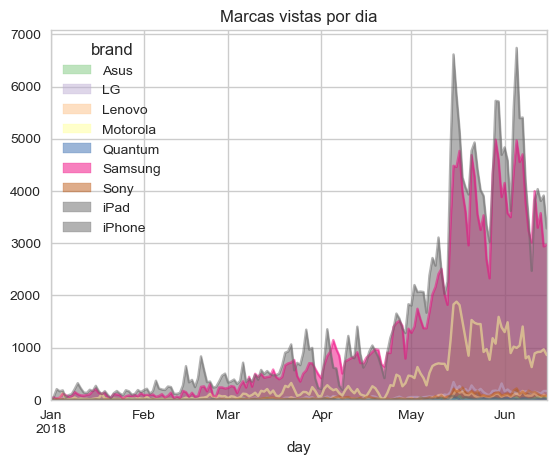

In [29]:
df2 = df.loc[df['event'] == 'viewed product',('day','brand')].groupby(['day','brand'])['brand'].count().unstack()\
        .plot(kind = 'area', stacked = False, title = 'Marcas vistas por dia', colormap='Accent')

plt.show()

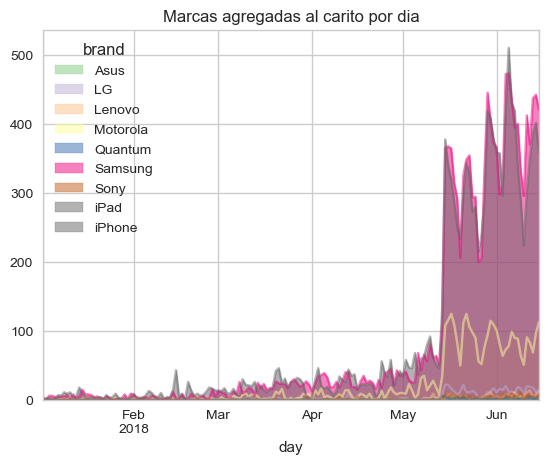

In [30]:
df2 = df.loc[df['event'] == 'checkout',('day','brand')].groupby(['day','brand'])['brand'].count().unstack()\
        .plot(kind = 'area', stacked = False, title = 'Marcas agregadas al carito por dia', colormap='Accent')

plt.show()


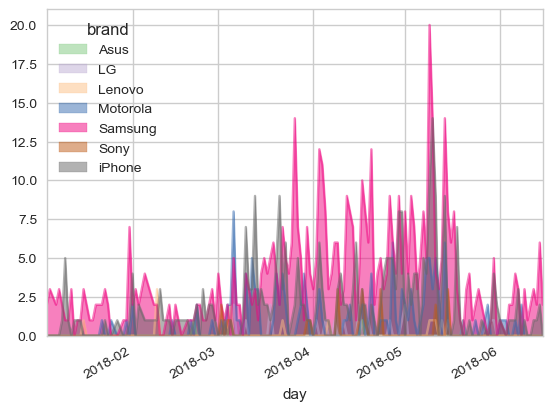

In [31]:
df2 = df.loc[df['event'] == 'conversion',('day','brand')].groupby(['day','brand'])['brand'].count().unstack().plot(kind = 'area', colormap = 'Accent', stacked = False)
df2

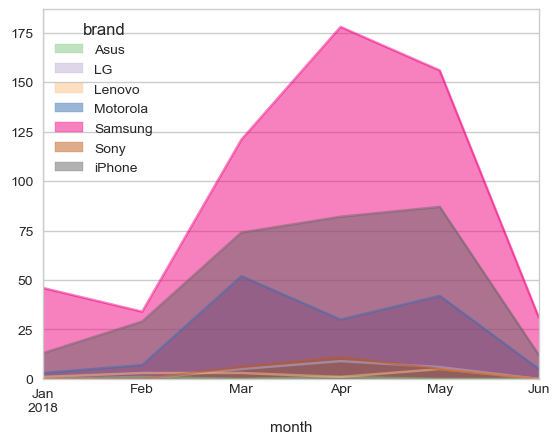

In [32]:
df2 = df.loc[df['event'] == 'conversion',('month','brand')].groupby(['month','brand'])['brand'].count().unstack().plot(kind = 'area', colormap = 'Accent', stacked = False)
df2

En los productos vistos y agregados al carrito se presenta el pico en mayo.  Sin embargo en los productos comprados no es tan marcado.
Si este pico se debe a una campaña, ésta logró atraer nuevos clientes, aumentaron las visualizaciones y el checkout de productos, sin embargo el aumento en las compras fue momentáneo.

##### 3.2.1 Modelos

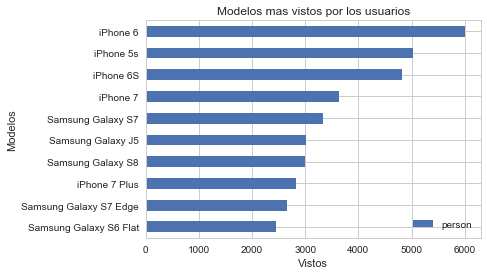

In [33]:
vp = df.loc[df.event=='viewed product', ['person', 'model']]
vp = vp.drop_duplicates(subset=['person', 'model'], keep='first')
vp = vp.groupby('model').count().sort_values('person', ascending=False).head(10)
%matplotlib inline
vp.plot.barh(stacked=True, rot=0, sort_columns=False).invert_yaxis()
plt.ylabel('Modelos')
plt.xlabel('Vistos')
plt.title('Modelos mas vistos por los usuarios')
plt.show()

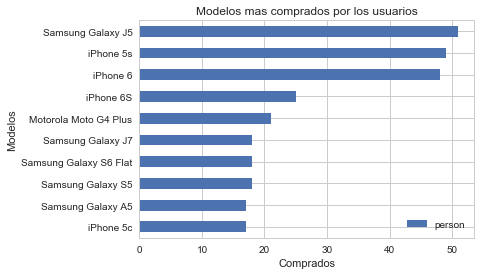

In [34]:
vp = df.loc[df.event=='conversion', ['person', 'model']]
vp = vp.drop_duplicates(subset=['person', 'model'], keep='first')
vp = vp.groupby('model').count().sort_values('person', ascending=False).head(10)
%matplotlib inline
vp.plot.barh(stacked=True, rot=0, sort_columns=False).invert_yaxis()
plt.ylabel('Modelos')
plt.xlabel('Comprados')
plt.title('Modelos mas comprados por los usuarios')
plt.show()

### 3.3 Métricas del comportamiento de los usuarios

##### Viewed product / checkout / conversion
Cada usuario puede tener cero o más eventos viewed product para el mismo SKU para el que tuvieron un evento checkout.  Es decir, pueden haber visto varias veces el producto, y luego hacer click en el botón comprar una sola vez.
Al mismo tiempo, los usuarios pueden tener eventos checkout sin eventos viewed product para el mismo SKU, esto sucede cuando por ejemplo, entran directamente al link de checkout.

In [35]:
# filtro los eventos de tipo "viewed product"
viewed = df.loc[df['event'] == 'viewed product',('person','timestamp','sku')].sort_values(by=['person','timestamp','sku'])
viewed = viewed.rename(columns = {'timestamp':'timestamp_viewed'})
print('Total eventos de tipo viewed product:', viewed.count()[0])

Total eventos de tipo viewed product: 517566


In [36]:
# filtro los eventos de tipo "checkout"
co = df.loc[df['event'] == 'checkout',('timestamp','event','person','sku')]
co = co.rename(columns = {'timestamp':'timestamp_checkout'})
co.set_index(['person','timestamp_checkout','sku'])
#co = co.drop('event', axis=1)
print('Total eventos de tipo checkout:', co.count()[0])

Total eventos de tipo checkout: 31889


In [37]:
# con un join obtengo las personas que tuvieron un evento de tipo "viewed product" 
# y un evento de tipo "checkout" para el mismo SKU

viewjoin = viewed.merge(co, how='inner')
# me quedo sólo con los que tuvieron el evento checkout después del evento viewed product
viewjoin = viewjoin.loc[viewjoin['timestamp_viewed'] < viewjoin['timestamp_checkout'],:]

print('Total de eventos checkout que tuvieron un al menos un viewed product:',viewjoin.loc[:,('person','timestamp_checkout')].drop_duplicates().count()[0])
# calculo el porcentaje
converted = viewjoin.loc[:,('person','timestamp_checkout')].drop_duplicates().count()[0]/viewed.count()[0]
print('Porcentaje de productos vistos que pasaron al carrito:', round(converted * 100),'%')

Total de eventos checkout que tuvieron un al menos un viewed product: 30976
Porcentaje de productos vistos que pasaron al carrito: 6.0 %


In [38]:
# filtro los eventos de tipo "conversion"
conv = df.loc[df['event'] == 'conversion',('timestamp','event','person','sku')]
conv.set_index(['person','sku'])
#co = co.drop('event', axis=1)
print('Total eventos de tipo conversion:', conv.count()[0])

Total eventos de tipo conversion: 1059


In [39]:
# con un join obtengo las personas que tuvieron un evento de tipo "viewed product", un evento de tipo "checkout" 
# y un evento "conversion" para el mismo SKU

#viewjoin = viewed.join(co.set_index(['person','day','sku']), on=['person','day','sku'])
convjoin = viewjoin.loc[:,('person','timestamp_checkout','sku')].merge(conv, how='inner')
# me quedo sólo con los que tuvieron el evento conversion después del evento checkout
convjoin = convjoin.loc[convjoin['timestamp_checkout'] < convjoin['timestamp'],:]

# calculo el porcentaje
converted = convjoin.loc[:,('person','timestamp')].drop_duplicates().count()[0]/viewed.count()[1]
print('Porcentaje de productos vistos que fueron comprados:', round(converted * 100,2),'%',)

converted = convjoin.loc[:,('person','timestamp')].drop_duplicates().count()[0]/viewjoin.loc[:,('person','timestamp_checkout')].drop_duplicates().count()[0]
print('Porcentaje de productos en el carrito que fueron comprados:', round(converted * 100,2),'%')


Porcentaje de productos vistos que fueron comprados: 0.16 %
Porcentaje de productos en el carrito que fueron comprados: 2.6 %


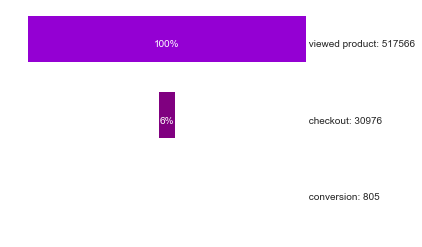

In [40]:
step = ['viewed product', 'checkout', 'conversion']
values = [viewed.count()[0], viewjoin.loc[:,('person','timestamp_checkout')].drop_duplicates().count()[0], convjoin.loc[:,('person','timestamp')].drop_duplicates().count()[0]]
data = pd.DataFrame({'step':step,'val':values})

# Función para graficar el funnel
def funnel_chart(df, show_n=True,show_pct='NA'):
  #set up data frame
  df['val']=df['val'].astype(int)
  my_max=df['val'][0]
  df = df.sort_values('val',ascending=False).reset_index(drop=True)
  df['pct_of_whole']=round((df['val']/my_max)*100).astype(int)
  pct_change=[100]
  for j in range(1,len(df['val'])):
    pct_change.append(int(round(df['val'][j]/df['val'][j-1]*100)))
  df['pct_change']=pct_change
  df = df.sort_values('val').reset_index(drop=True)
  df['left']=(my_max-df['val'])/2
  df['col']=['indigo','purple','darkviolet']

  #initialize plot
  fig, ax = plt.subplots()
  for i in range(len(df['step'])):
    ax.barh(0.5*i+0.5, df['val'][i], height=0.3, left=df['left'][i], align='center', color=df['col'][i],alpha = 1.0, label=df['step'][i])
    if(show_n==True):
      ax.annotate(' ' + df['step'][i] + ': ' + str(df['val'][i]),xy=(my_max,0.5*i+0.45),horizontalalignment='left')
    else:
      ax.annotate(' ' + df['step'][i],xy=(my_max,0.5*i+0.45),horizontalalignment='left')
    if(show_pct=='of whole'):
      ax.annotate(str(df['pct_of_whole'][i]) + '%' ,xy=(my_max/2,0.5*i+0.45),horizontalalignment='center',color='white')
    elif(show_pct=='of last step'):
      ax.annotate(str(df['pct_change'][i]) + '%' ,xy=(my_max/2,0.5*i+0.45),horizontalalignment='center',color='white')


  #remove border and align chart
  ax.axis('off')
  fig.subplots_adjust(right=0.8)

  return fig

# Gráfico
fig = funnel_chart(data,show_n=True,show_pct='of last step')

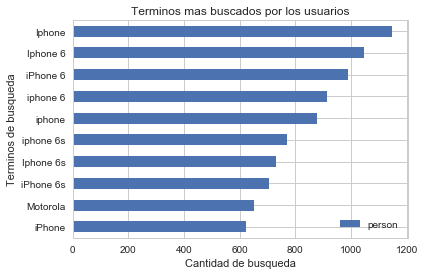

In [41]:
st = df.loc[:,['person','search_term']]
st = st.groupby('search_term').count()
st = st.sort_values(by=['person'], ascending=False).head(10)
%matplotlib inline
st.plot.barh(stacked=True, rot=0, sort_columns=False).invert_yaxis()
plt.ylabel('Terminos de busqueda')
plt.xlabel('Cantidad de busqueda')
plt.title('Terminos mas buscados por los usuarios')
plt.show()


#### 3.4 Tipos de eventos por persona

In [42]:
print('Cantidad de personas:',df['person'].nunique())

# Armamos un dataframe que contenga por persona la cantidad de eventos de cada tipo para hacer varios análisis sobre éste
dfperson = df.loc[:,('person','event','timestamp')].pivot_table(index='person', columns='event', values='timestamp', aggfunc='count')

Cantidad de personas: 25872


Haciendo un análisis de la cantidad de personas con evento, vemos que todas las personas de la muestra tienen un evento checkout.  Además, al haber tomado sólo personas de Brasil, todas tienen al menos un evento visited site.

Por otro lado, las 471 personas que sólo tienen un evento de tipo checkout también quedan excluidas.

Checkout es cuando el usuario hace click en comprar.

Todas las personas de la base tienen un evento checkout.  Está la muestra tomada sólo para estos clientes?  Si es así, estamos perdiendo información de los usuarios que abandonan el sitio antes de hacer el checkout, qué productos ven o qué patrones existen que evitan que lleguen al checkout.  Cómo tener en cuenta esto para evitar el sesgo?


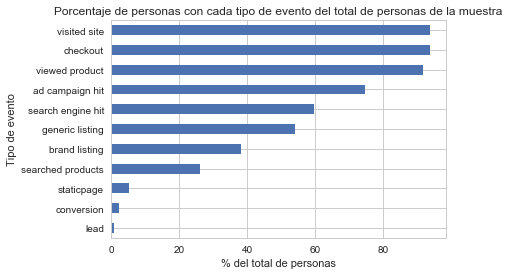

In [43]:
data = dfperson.count().sort_values(ascending=True)
data = data / 27624 * 100
#print(data)
data.plot.barh()
plt.ylabel('Tipo de evento')
plt.xlabel('% del total de personas')
plt.title('Porcentaje de personas con cada tipo de evento del total de personas de la muestra')
plt.show()

#### 3.5 Sesiones por usuario
Cada sesión agrupa los eventos separados entre sí no más de 30 minutos.

In [44]:
# Definimos un límite de tiempo entre eventos
T = timedelta(seconds=30*60)
# Ordenamos el dataset por timestamp
df = df.sort_values(by=['timestamp'])
# Agregamos una columna con el timestamp anterior
df['last_timestamp'] = df.groupby(['person'])['timestamp'].shift()
# Crear flag de nueva sesión
df['new_session'] = (((df['timestamp']
                            - df['last_timestamp'])>=T) | (df['last_timestamp'].isnull())).astype(int)
df['inc'] = df.groupby('person')['new_session'].cumsum()
# Creamos el id de sesión
df['session_id'] = df['person'].astype(str) + '_' + df['inc'].astype(str)
df = df.drop('inc', axis=1)

Agrupamos la cantidad de eventos de cada tipo por sesión

In [45]:
dfsesion = df.loc[:,('session_id','event','timestamp')].pivot_table(index='session_id', columns='event', values='timestamp', aggfunc='count')
dfsesion.columns = dfsesion.columns.astype('object')
dfsesion = dfsesion.reset_index()

##### Verificación de las nuevas sesiones
- Verificar si todas las sesiones tienen uno o más visited site, ya que es el evento que identifica una visita al sitio.

In [46]:
print('Cantidad total de sesiones:',df['new_session'].sum())

 # buscar visited site NaN
print('Cantidad de sesiones sin visited site:',
      pd.DataFrame({'session_id':dfsesion.loc[(dfsesion['visited site'].isnull()
                                        ),:]['session_id']}
                    ).merge(df.loc[(df['new_session']==1)
                                   ,('person','timestamp','last_timestamp','new_session','inc','session_id','event'
                                    )].sort_values(by=['person','timestamp'])).count()[0]
     )
print('Cantidad de sesiones con más de un visited site:',
      pd.DataFrame({'session_id':dfsesion.loc[(dfsesion['visited site'] > 2 
                                        ),:]['session_id']}
                    ).merge(df.loc[(df['new_session']==1)
                                   ,('person','timestamp','last_timestamp','new_session','inc','session_id','event'
                                    )].sort_values(by=['person','timestamp'])).count()[0]
     )

Cantidad total de sesiones: 85995
Cantidad de sesiones sin visited site: 1566
Cantidad de sesiones con más de un visited site: 65


La cantidad de sesiones que podrían estar delimitadas de forma incorrecta representa una porción muy pequeña del total de las sesiones.

##### 3.5.1 Análisis por sesión
Creamos un dataframe con las características de cada sesión para hacer el análisis
- eventos por sesión
- sesiones por usuario


In [47]:
# Creamos un dataframe por sesión con las características de cada una
dfsesionfeat = df.groupby(['session_id','person']).agg({'event':'count', 'timestamp':['min','max'], 'sku':'nunique'})
dfsesionfeat.columns = dfsesionfeat.columns.droplevel()
dfsesionfeat.columns = ['event count','min timestamp','max timestamp','unique skus']
# Agregamos la duración en segundos de cada sesión
dfsesionfeat['time lapsed'] = ((dfsesionfeat['max timestamp']) - dfsesionfeat['min timestamp']).astype('timedelta64[s]')
# Eliminamos índices para hacer el merge
dfsesionfeat = dfsesionfeat.reset_index()
#dfsesionfeat = dfsesionfeat.drop(['index'], axis=1)
# Hacemos un join para agregar la cantidad de cada tipo de evento por sesión
dfsesionfeat = dfsesionfeat.merge(dfsesion)


##### Cantidad de sesiones por usuario
Por usuario podemos ver que más del 50% tiene una sola sesión, y el 75% de las personas tienen entre 1 y 3 visitas.
Se puede ver en un gráfico de porcentajes de las personas que tienen cada cantidad de sesiones o en un histograma de la cantidad de sesiones por persona, donde la línea vertical roja indica el 75% de las personas.  Habría que buscar la mejor forma de representarlo.

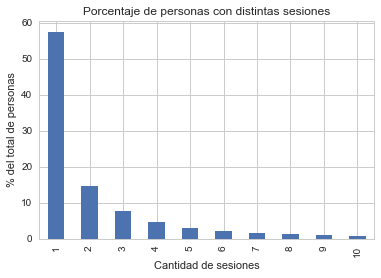

In [48]:
sesiones = df.loc[:,('person','session_id')].drop_duplicates().groupby('person').count()

(sesiones['session_id'].value_counts(normalize=True)*100)[0:10].plot.bar()
plt.xlabel('Cantidad de sesiones')
plt.ylabel('% del total de personas')
plt.title('Porcentaje de personas con distintas sesiones')
plt.show()

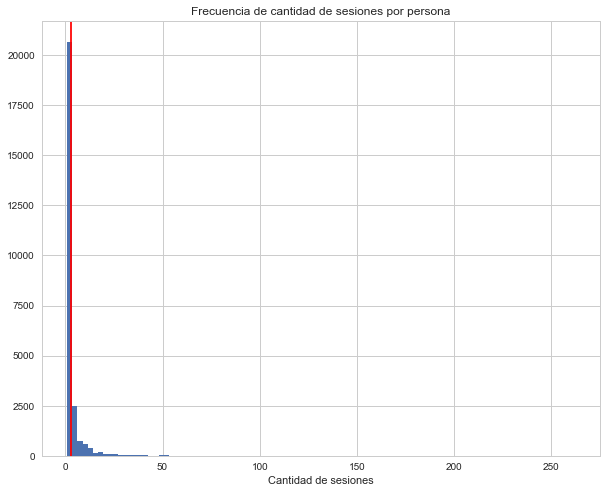

In [49]:
quant = sesiones['session_id'].quantile([0,.25,.5,.75,1])
plt.figure(figsize=(10,8))
plt.hist(sesiones['session_id'], bins=100)
plt.axvline(x=quant[.75], color='r', linestyle='-')
plt.xlabel('Cantidad de sesiones')
plt.title('Frecuencia de cantidad de sesiones por persona')
plt.show()

##### Eventos por sesión
Vemos que la cantidad de eventos por sesión sigue una distribución geométrica con una media de 11 eventos y una mediana de 7 eventos por sesión.

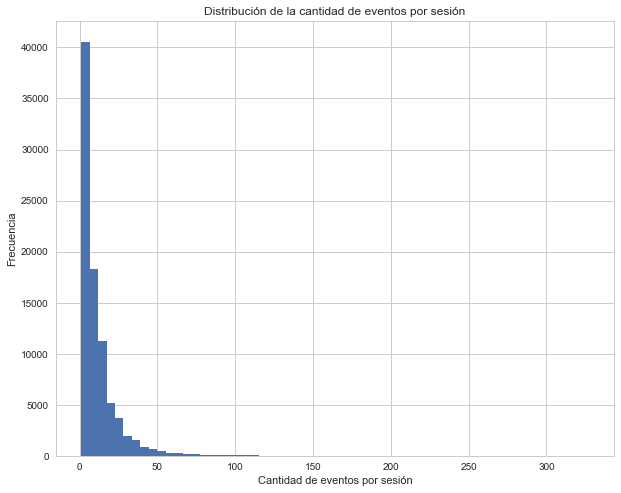

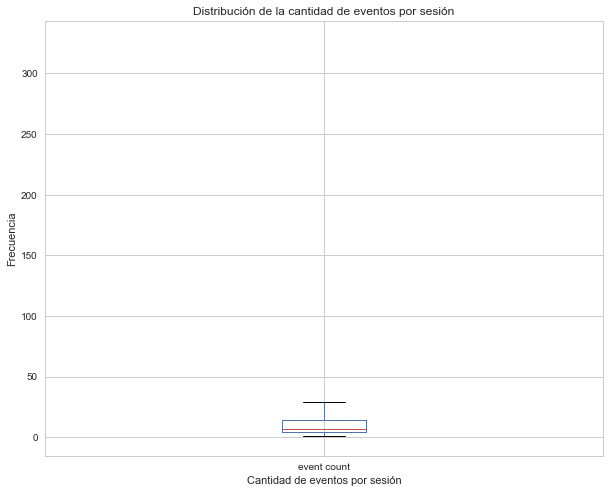

Mediana de eventos por sesión: 7.0
Promedio de eventos por sesión: 11


In [50]:
# suma de los eventos por sesión
data = dfsesionfeat['event count']
plt.rcParams["figure.figsize"] = [10,8]
data.plot.hist(bins=60)
plt.xlabel('Cantidad de eventos por sesión')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de eventos por sesión')
plt.show()

data.plot.box()
plt.xlabel('Cantidad de eventos por sesión')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de eventos por sesión')
plt.show()
print('Mediana de eventos por sesión:', round(np.median(data)))
print('Promedio de eventos por sesión:', round(np.mean(data)))

## Ingreso de usuarios al sitio
- La mayoría de los usuarios nuevos llegan al sitio con dos eventos, ad campaign hit y search engine hit.  Cuando se trata de usuarios que vuelven, lo más común es que no entren a través de ad campaign o search engine.
- De qué canales vienen? La mayoría vienen de canales pagos cuando el evento con el que ingresan es ad campaign hit.  Si ingresan sólo con search engine hit, el canal más frecuente es Organic.  Cuando no llegan a través de los anteriores, los canales más frecuentes son Direct y Referral.
- Respecto de las regiones desde las cuales ingresan los usuarios, vemos que la mayoría ingresan desde Sao Paulo, mientras que hay una gran cantidad de visitas para las cuales no hay registro de la región.

Vemos que los ingresos al sitio se pueden dar con los eventos visited site, acompañados en muchos casos de ad campaign hit o search engine hit.

In [51]:
# Analizamos el ingreso de usuarios
data = dfsesionfeat.loc[dfsesionfeat['visited site'].notnull(),('session_id','person','ad campaign hit','search engine hit')]
data['ad campaign and search hit'] = (data['ad campaign hit'].notnull()) & (data['search engine hit'].notnull())
data['ad campaign'] = (data['ad campaign hit'].notnull()) & (data['search engine hit'].isnull())
data['search engine'] = (data['ad campaign hit'].isnull()) & (data['search engine hit'].notnull())
data['no hit'] = (data['ad campaign hit'].isnull()) & (data['search engine hit'].isnull())

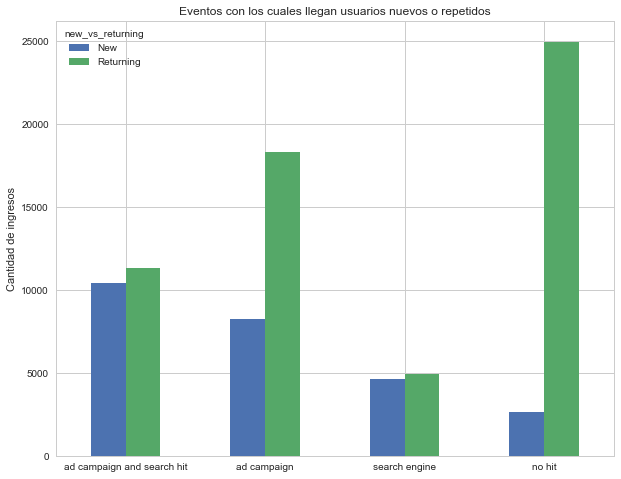

In [52]:
# Con qué evento ingresan y si son nuevos o no
plotdata = df.loc[df['event']=='visited site',('session_id','channel','new_vs_returning','city','region','device_type','screen_resolution','operating_system_version','browser_version')].merge(data.loc[:,('session_id','ad campaign and search hit','ad campaign','search engine','no hit')]).groupby('new_vs_returning').sum()
plt.rcParams["figure.figsize"] = [10,8]
plotdata.T.plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('Cantidad de ingresos')
plt.title('Eventos con los cuales llegan usuarios nuevos o repetidos')
plt.show()

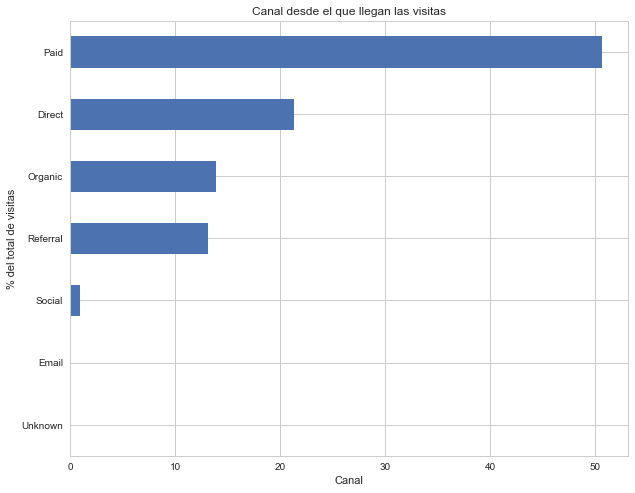

In [53]:
(df.loc[df['event'] == 'visited site']['channel'].value_counts(normalize=True, ascending=True)*100).plot.barh()
plt.xlabel('Canal')
plt.ylabel('% del total de visitas')
plt.title('Canal desde el que llegan las visitas')
plt.show()

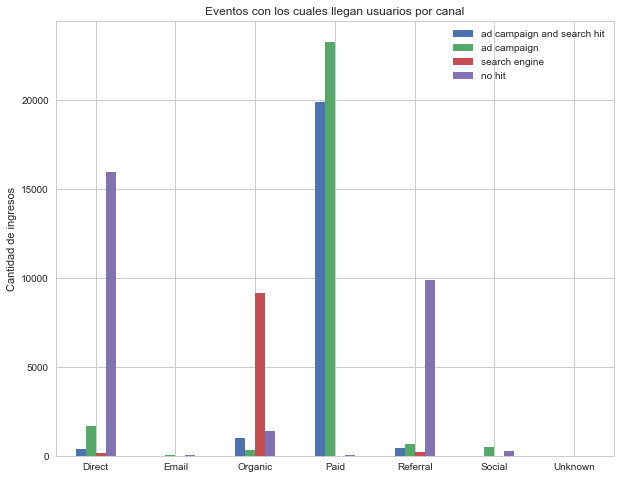

In [54]:
# Con qué evento ingresan según el canal
plotdata = df.loc[df['event']=='visited site',('session_id','channel','new_vs_returning','city','region','device_type','screen_resolution','operating_system_version','browser_version')].merge(data.loc[:,('session_id','ad campaign and search hit','ad campaign','search engine','no hit')]).groupby('channel').sum()
plotdata.plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('Cantidad de ingresos')
plt.title('Eventos con los cuales llegan usuarios por canal')
plt.show()

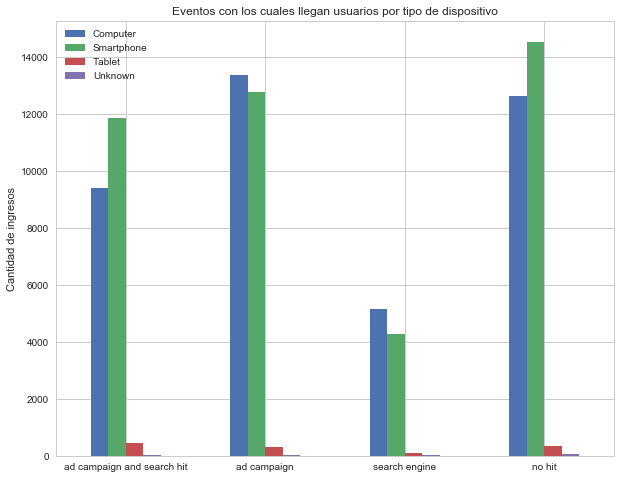

In [55]:
# Con qué evento ingresan según el dispositivo

plotdata = df.loc[df['event']=='visited site',('session_id','channel','new_vs_returning','city','region','device_type','screen_resolution','operating_system_version','browser_version')].merge(data.loc[:,('session_id','ad campaign and search hit','ad campaign','search engine','no hit')]).groupby('device_type').sum()
(plotdata.T).plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('Cantidad de ingresos')
plt.title('Eventos con los cuales llegan usuarios por tipo de dispositivo')
plt.legend(plotdata.index)
plt.show()


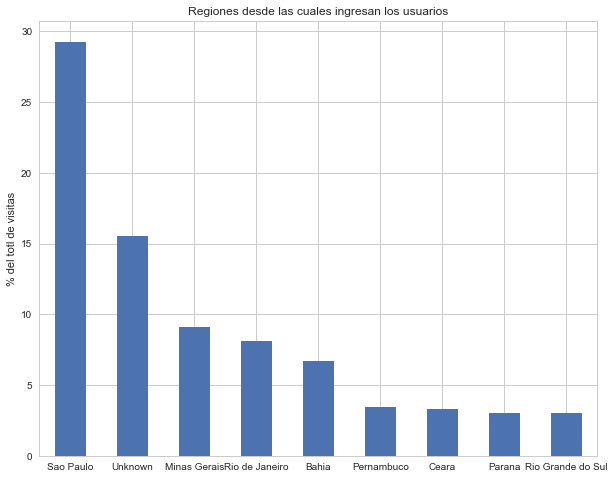

In [56]:
(df['region'].value_counts(normalize=True, ascending=False)[0:9]*100).plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('% del totl de visitas')
plt.title('Regiones desde las cuales ingresan los usuarios')
plt.show()

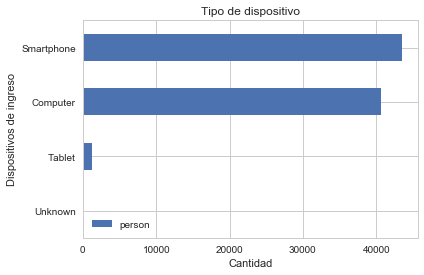

Los usuarios ingresan mayormente por el Smartphone lo que significa que debería haber más campañas orientadas a dispositivos móviles.


In [57]:
dt = df.loc[:, ['person', 'device_type']]
dt = dt.groupby('device_type').count().sort_values(by='person', ascending=False)
%matplotlib inline
dt.plot.barh(stacked=True, rot=0, sort_columns=False).invert_yaxis()
plt.ylabel('Dispositivos de ingreso')
plt.xlabel('Cantidad')
plt.title('Tipo de dispositivo')
plt.show()
print("Los usuarios ingresan mayormente por el Smartphone lo que significa que debería haber más campañas orientadas a dispositivos móviles.")

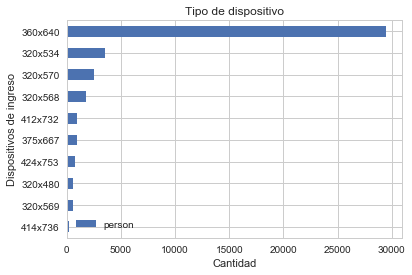

Mirando las resoluciones de los dispositivos moviles que ingresan, podemos determinar si las personas qeu ingresan al sitiolo hacen desde un celular Baja / Media / Alta gama, y calcular que tipo de target es al que hay que apuntar para aumentar los cllientes


In [58]:
sr = df.loc[df.device_type=='Smartphone', ['person', 'screen_resolution']]
sr = sr.groupby('screen_resolution').count().sort_values(by='person', ascending=False).head(10)
%matplotlib inline
sr.plot.barh(stacked=True, rot=0, sort_columns=False).invert_yaxis()
plt.ylabel('Dispositivos de ingreso')
plt.xlabel('Cantidad')
plt.title('Tipo de dispositivo')
plt.show()
print("Mirando las resoluciones de los dispositivos moviles que ingresan, podemos determinar si las personas qeu ingresan al sitio\
lo hacen desde un celular Baja / Media / Alta gama, y calcular que tipo de target es al que hay que apuntar para aumentar los cllientes")